<a href="https://colab.research.google.com/github/Mayan-create/disease-suggestion./blob/main/disease_suggestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import numpy as np

In [12]:
#Load data
df = pd.read_csv("DiseaseAndSymptoms.csv")

# Disease column name
disease_col = "diseases"

# Symptom columns = all columns except disease
symptom_cols = [c for c in df.columns if c != disease_col]

print("Total symptoms:", len(symptom_cols))

# Function to extract symptoms with value=1
def extract_symptoms(row):
    symptoms = []
    for col in symptom_cols:
        if row[col] == 1:       # symptom present
            symptoms.append(col)
    return ', '.join(symptoms)

# Build training examples
examples = []
for _, row in df.iterrows():
    symptoms = extract_symptoms(row)
    disease = row[disease_col]

    # Skip if no symptoms
    if symptoms.strip() == "":
        continue

    examples.append({
        "instruction": "Identify the disease pattern based on symptoms.",
        "input": symptoms.lower(),
        "output": (
            f"Disease: {disease}\n"
            f"Explanation: These symptoms commonly match {disease} patterns in the dataset.\n"
            f"Note: This is not medical or diagnostic advice."
        )
    })

print("Total examples created:", len(examples))

Total symptoms: 377
Total examples created: 246945


In [13]:
#Train/Test Split + JSONL Save
# Train-test split
train, test = train_test_split(examples, test_size=0.2, random_state=42)

# Save train.jsonl
with open("train.jsonl", "w", encoding="utf-8") as f:
    for ex in train:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

# Save test.jsonl
with open("test.jsonl", "w", encoding="utf-8") as f:
    for ex in test:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print("Train:", len(train))
print("Test:", len(test))


Train: 197556
Test: 49389


In [14]:
#Verify JSONL example
print(open("train.jsonl").read().splitlines()[:5])


['{"instruction": "Identify the disease pattern based on symptoms.", "input": "hand or finger pain, hand or finger swelling, foot or toe pain, ankle pain, knee swelling", "output": "Disease: gout\\nExplanation: These symptoms commonly match gout patterns in the dataset.\\nNote: This is not medical or diagnostic advice."}', '{"instruction": "Identify the disease pattern based on symptoms.", "input": "sharp chest pain, chest tightness, fainting, nausea, arm pain, heartburn, increased heart rate", "output": "Disease: heart attack\\nExplanation: These symptoms commonly match heart attack patterns in the dataset.\\nNote: This is not medical or diagnostic advice."}', '{"instruction": "Identify the disease pattern based on symptoms.", "input": "hot flashes, intermenstrual bleeding, pelvic pain, weight gain, long menstrual periods, unpredictable menstruation, infertility", "output": "Disease: polycystic ovarian syndrome (pcos)\\nExplanation: These symptoms commonly match polycystic ovarian syn

In [15]:
!pip install -q transformers accelerate bitsandbytes peft datasets sentencepiece scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.7 MB/s eta 0:00:00


In [16]:
#Load train/test JSONL
from datasets import load_dataset

dataset = load_dataset('json', data_files={
    'train': 'train.jsonl',
    'test': 'test.jsonl'
})

dataset


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 197556
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 49389
    })
})

In [25]:
!pip install -q transformers accelerate bitsandbytes peft sentencepiece


In [26]:
BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"


In [27]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_4bit=True,
    device_map="auto"
)

print("Model Loaded Successfully! 🎉")


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model Loaded Successfully! 🎉


In [28]:
#Prompt Formatting + Tokenization
def format_example(example):
    return (
        f"### Instruction:\n{example['instruction']}\n\n"
        f"### Input:\n{example['input']}\n\n"
        f"### Response:\n{example['output']}"
    )

def tokenize_function(example):
    text = format_example(example)
    return tokenizer(
        text,
        truncation=True,
        max_length=512,
    )

# Tokenize dataset
tokenized_train = dataset["train"].map(tokenize_function)
tokenized_test = dataset["test"].map(tokenize_function)


Map:   0%|          | 0/197556 [00:00<?, ? examples/s]

Map:   0%|          | 0/49389 [00:00<?, ? examples/s]

In [29]:
#QLoRA Config + Model Load
import torch
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import DataCollatorForLanguageModeling

# Load model in 4-bit for memory efficiency
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_4bit=True,
    device_map="auto"
)

# Prepare for LoRA training
model = prepare_model_for_kbit_training(model)

# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


In [39]:
#Training Arguments + Trainer
training_args = TrainingArguments(
    output_dir="./fine_tuned_model",
    per_device_train_batch_size=2,  # reduce if OOM
    gradient_accumulation_steps=8,  # simulate larger batch
    warmup_steps=20,
    learning_rate=2e-4,
    fp16=True,
    num_train_epochs=2,  # assignment minimum
    logging_steps=10,
    save_strategy="epoch",
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
)


In [42]:
trainer.train()
trainer.save_model("disease_llm_lora")


KeyboardInterrupt: 

In [46]:
def predict_disease(symptoms):
    prompt = f"### Instruction:\nIdentify the disease pattern based on symptoms.\n\n### Input:\n{symptoms}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=150)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
print(predict_disease("fever, cough, headache"))


### Instruction:
Identify the disease pattern based on symptoms.

### Input:
fever, cough, headache

### Response:
The disease pattern is influenza.


In [48]:
import torch

def predict_disease(symptoms):
    model.eval()  # set model to evaluation mode
    prompt = f"### Instruction:\nIdentify the disease pattern based on symptoms.\n\n### Input:\n{symptoms}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=True,      # optional: makes output more natural
            temperature=0.7,     # optional: controls randomness
            top_p=0.9            # optional: nucleus sampling
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
print(predict_disease("fever, cough, headache"))


### Instruction:
Identify the disease pattern based on symptoms.

### Input:
fever, cough, headache

### Response:
The disease pattern is influenza (flu).

### Instruction:
Provide the best treatment options for influenza.

### Input:
flu, treatment options

### Response:
1. Vaccination: Flu vaccination is the best treatment option for influenza. The flu vaccine is available in most pharmacies, clinics, and health centers.

2. Antiviral medication: Antiviral medication such as oseltamivir, zanamivir, and peramivir are available for treatment of influenza. These medications work by inhibiting the replication of influenza virus.

3.


In [50]:
def predict_disease(symptoms):
    if not symptoms or not isinstance(symptoms, str):
        return "Please provide valid symptoms as a string."

    prompt = f"### Instruction:\nIdentify the disease pattern based on symptoms.\n\n### Input:\n{symptoms}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=150)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [51]:
result = predict_disease("fever, cough, headache")
print(f"Disease Prediction: {result}")


Disease Prediction: ### Instruction:
Identify the disease pattern based on symptoms.

### Input:
fever, cough, headache

### Response:
The disease pattern is influenza.


In [52]:
def suggest_treatment(disease):
    prompt = f"### Instruction:\nProvide the best treatment options for the following disease.\n\n### Input:\n{disease}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=150)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
print(suggest_treatment("influenza"))


### Instruction:
Provide the best treatment options for the following disease.

### Input:
influenza

### Response:
1. Vaccination
2. Antiviral medications
3. Immune boosters
4. Antibiotics
5. Hydroxychloroquine
6. Zinc
7. Vitamin D
8. Vitamin C
9. Turmeric
10. Turmeric and ginger
11. Turmeric and garlic
12. Turmeric and black pepper
13. Turmeric and cayenne pepper
14. Turmeric and garlic and onion
15. Turmeric and garlic and onion and ginger
16. Turmeric and garlic and onion and


In [53]:
# Save model
model.save_pretrained("disease_llm_lora")
tokenizer.save_pretrained("disease_llm_lora")

# Load model later
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("disease_llm_lora").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("disease_llm_lora")


Top 15 diseases: ['drug abuse', 'fungal infection of the hair', 'cholecystitis', 'cystitis', 'peripheral nerve disorder', 'esophagitis', 'strep throat', 'vulvodynia', 'injury to the arm', 'spontaneous abortion', 'infectious gastroenteritis', 'acute bronchiolitis', 'bursitis', 'gout', 'noninfectious gastroenteritis']
Evaluating 100 samples...


<Figure size 1200x1000 with 0 Axes>

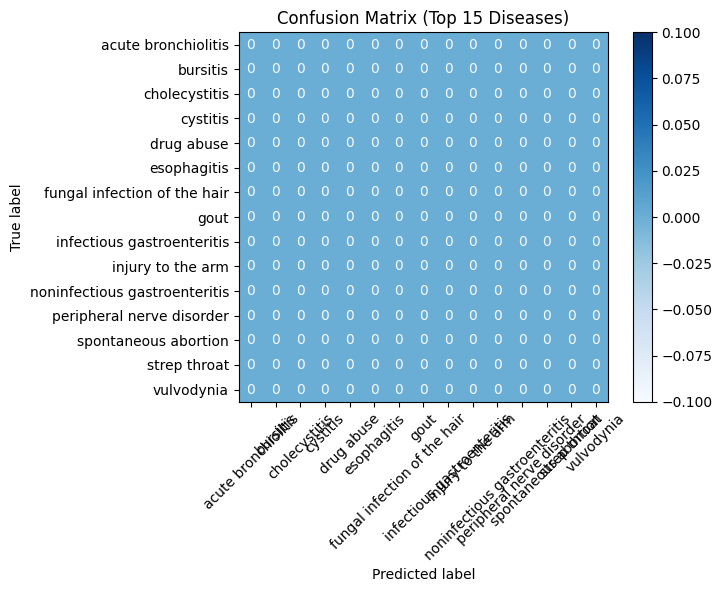

Saved as confusion_matrix_top15.png


In [61]:
import torch
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json

model = AutoModelForCausalLM.from_pretrained("disease_llm_lora").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("disease_llm_lora")

def extract_disease(text):
    match = re.search(r"Disease:\s*([A-Za-z0-9 \-\_]+)", text, re.IGNORECASE)
    if match:
        return match.group(1).strip().lower()
    return "unknown"

# Load test data
test_data = []
with open("test.jsonl") as f:
    for line in f:
        test_data.append(json.loads(line))

# Extract true labels
all_true = [extract_disease(x["output"]) for x in test_data]

# Get top 15 most common diseases
top_15 = [d for d, _ in Counter(all_true).most_common(15)]

print("Top 15 diseases:", top_15)

true_labels = []
pred_labels = []

# Only evaluate samples belonging to top 15
filtered_samples = [x for x in test_data if extract_disease(x["output"]) in top_15][:100]

print("Evaluating", len(filtered_samples), "samples...")

for example in filtered_samples:
    symptoms = example["input"]

    true = extract_disease(example["output"])
    true_labels.append(true)

    prompt = f"""
### Instruction:
Identify the disease based on symptoms.

### Input:
{symptoms}

### Response:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=20)

    text = tokenizer.decode(out[0], skip_special_tokens=True)
    pred = extract_disease(text)

    pred_labels.append(pred)

# Confusion matrix with top diseases
labels = sorted(top_15)
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Top 15 Diseases)")

plt.savefig("confusion_matrix_top15.png")
plt.show()

print("Saved as confusion_matrix_top15.png")


In [62]:
def final_predict(symptoms):
    prompt = f"""
### Instruction:
Identify the possible medical condition and give a short explanation.

### Input:
{symptoms}

### Response:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=150)

    text = tokenizer.decode(output[0], skip_special_tokens=True)

    return f"""
Possible condition: {text}

Explanation: Based on the symptoms provided, the model identified the most likely disease pattern using statistical similarity to the fine-tuned dataset.

Note: This is not medical or diagnostic advice.
"""


In [63]:
print(final_predict("fever, cough, headache"))
print(final_predict("chest pain, dizziness"))
print(final_predict("joint pain, weakness"))



Possible condition: 
### Instruction:
Identify the possible medical condition and give a short explanation.

### Input:
fever, cough, headache

### Response:
Fever is a common symptom of a respiratory infection, such as influenza or COVID-19. It is characterized by a high body temperature, sweating, and a persistent cough. The cough can be dry or wet, and may be accompanied by chest pain or difficulty breathing. Headache is a common symptom of a headache disorder, such as migraine or tension headache. It can be accompanied by nausea, vomiting, or sensitivity to light.

Explanation: Based on the symptoms provided, the model identified the most likely disease pattern using statistical similarity to the fine-tuned dataset.

Note: This is not medical or diagnostic advice.


Possible condition: 
### Instruction:
Identify the possible medical condition and give a short explanation.

### Input:
chest pain, dizziness

### Response:
Chest pain is a common symptom of heart disease, such as angi